# 서울시 구별 CCTV 현황 분석하기

### 본 장은 ["민형기 저자의 파이썬으로 데이터 주무르기"](https://pinkwink.kr) 1장 내용입니다.

## 분석 목표
* 서울시 각 구별 CCTV수를 파악하고, 인구대비 CCTV 비율을 파악해서 순위 비교
* 인구대비 CCTV의 평균치를 확인하고 그로부터 CCTV가 과하게 부족한 구를 확인.

## 파이썬 공부 목표
* JupyterLab 사용환경을 익히고 Python 기본 문법을 확인
* Pandas와 Matplotlib의 기본적 사용법을 확인
* 단순한 그래프 표현에서 한 단계 더 나아가 경향을 확인하고 시각화하는 기초 확인

In [3]:
# pandas 패키지 불러오기
import pandas as pd

In [97]:
# 자료 불러오기
CCTV_Seoul = pd.read_csv("CCTV_Seoul.csv", encoding="utf-8")
CCTV_Seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [3]:
# 컬럼명 조회
CCTV_Seoul.columns

Index(['기관명', '소계', '2013년도 이전', '2014년', '2015년', '2016년'], dtype='object')

In [4]:
# 첫 번째 컬럼명 조회
CCTV_Seoul.columns[0]

'기관명'

In [98]:
# 첫 번째 컬럼명을 '기관명'에서 '구별'로 바꾸는 것이 좋을 듯함.
CCTV_Seoul.rename(columns={CCTV_Seoul.columns[0]: "구별"}, inplace=True)
CCTV_Seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


## 2-2. 엑셀파일 읽기 - 서울시 인구현황

In [99]:
# 엑셀로 미리 행정동을 제거하고, 노인인구를 넣는다.
# (데이터에 맞게 바뀐 코드)
pop_Seoul = pd.read_csv("pop_Seoul.csv", engine="python")
pop_Seoul.head()

,기간,자치구,세대,합계,합계.1,합계.2,한국인,한국인.1,한국인.2,등록외국인,등록외국인.1,등록외국인.2,세대당인구,65세이상고령자
0,2017.1/4,합계,4202888,10197604,5000005,5197599,9926968,4871560,5055408,270636,128445,142191,2,1321458
1,2017.1/4,종로구,72654,162820,79675,83145,153589,75611,77978,9231,4064,5167,2,25425
2,2017.1/4,중구,59481,133240,65790,67450,124312,61656,62656,8928,4134,4794,2,20764
3,2017.1/4,용산구,106544,244203,119132,125071,229456,111167,118289,14747,7965,6782,2,36231
4,2017.1/4,성동구,130868,311244,153768,157476,303380,150076,153304,7864,3692,4172,2,39997


In [100]:
pop_Seoul = pd.read_csv("pop_Seoul.csv", header=0, 
                        usecols = ['자치구', '합계', '한국인', '등록외국인', '65세이상고령자'],
                        engine="python")
pop_Seoul.head()

,자치구,합계,한국인,등록외국인,65세이상고령자
0,합계,10197604,9926968,270636,1321458
1,종로구,162820,153589,9231,25425
2,중구,133240,124312,8928,20764
3,용산구,244203,229456,14747,36231
4,성동구,311244,303380,7864,39997


In [101]:
pop_Seoul.rename(columns={pop_Seoul.columns[0]: '구별',
                         pop_Seoul.columns[1]: '총인구',
                         pop_Seoul.columns[2]: '내국인',
                         pop_Seoul.columns[3]: '외국인',
                         pop_Seoul.columns[4]: '고령자',
                        }, inplace=True)
pop_Seoul.head()

,구별,총인구,내국인,외국인,고령자
0,합계,10197604,9926968,270636,1321458
1,종로구,162820,153589,9231,25425
2,중구,133240,124312,8928,20764
3,용산구,244203,229456,14747,36231
4,성동구,311244,303380,7864,39997


# 3. Pandas 기초

In [102]:
import pandas as pd
import numpy as np

In [103]:
# 컬럼 슬라이싱
pop_Seoul[0:3]
pop_Seoul.구별

0       합계
1      종로구
2       중구
3      용산구
4      성동구
5      광진구
6     동대문구
7      중랑구
8      성북구
9      강북구
10     도봉구
11     노원구
12     은평구
13    서대문구
14     마포구
15     양천구
16     강서구
17     구로구
18     금천구
19    영등포구
20     동작구
21     관악구
22     서초구
23     강남구
24     송파구
25     강동구
Name: 구별, dtype: object

### loc 옵션:(행번호 + 열이름으로 조회해보고 싶을 때)
- loc는 location 옵션으로 슬라이싱할 때 loc 옵션을 이용해서 위치 값을 지정할 수 있다.
- [행,열] 구조로 이루어지며, 행은 숫자로, 열은 문자로 지정해야 한다.
- 복수의 열을 지정시 ['A', 'B', 'C']의 구조로 만들어서 pd.loc[:, ['A','B','C']] 구조가 되어야 한다.

In [104]:
# 인덱스는 모두(:), 컬럼은 ['구별','인구수']만
pop_Seoul.loc[:,:]
pop_Seoul.loc[:3,['구별','총인구']]

,구별,총인구
0,합계,10197604
1,종로구,162820
2,중구,133240
3,용산구,244203


In [105]:
# 두번째행부터 10번째까지
pop_Seoul.loc[2:10,['구별','총인구']]

,구별,총인구
2,중구,133240
3,용산구,244203
4,성동구,311244
5,광진구,372164
6,동대문구,369496
7,중랑구,414503
8,성북구,461260
9,강북구,330192
10,도봉구,348646


In [106]:
# 하나의 행만
pop_Seoul.loc[1:1,['구별','총인구']]

,구별,총인구
1,종로구,162820


### iloc 옵션(행번호 + 열번호로 조회하고 싶을 때)
- iloc는 integer location 옵션으로 loc와 달리 행과 열의 번호를 이용해서 데이터에 바로 접근할 때 사용한다.
- iloc을 사용하면 행이나 열의 범위를 지정하면 된다. 특히 콜론(:)을 사용하면 전체를 의미한다.?

In [107]:
pop_Seoul.iloc[3:5,3:4]

,외국인
3,14747
4,7864


In [108]:
# 복수의 행, 열을 선택할 때는 내부에 [] 구조로 만들어야 한다.


### 쿼리를 통한 데이터 검색
- 키워드에 데이터를 조회해오는 .query()

In [28]:
# 개별 검색
pop_Seoul.query("구별 == '송파구' | 총인구 >= 300000") 

,구별,총인구,내국인,외국인,고령자
0,합계,10197604,9926968,270636,1321458
4,성동구,311244,303380,7864,39997
5,광진구,372164,357211,14953,42214
6,동대문구,369496,354079,15417,54173
7,중랑구,414503,409882,4621,56774
8,성북구,461260,449773,11487,64692
9,강북구,330192,326686,3506,54813
10,도봉구,348646,346629,2017,51312
11,노원구,569384,565565,3819,71941
12,은평구,494388,489943,4445,72334


### 조건을 만족하는 데이터 검색

In [29]:
# 전체 데이터에서 조건에 해당되지 않으면 NaN 처리함.
pop_Seoul[pop_Seoul > 300000]

,구별,총인구,내국인,외국인,고령자
0,합계,10197604.0,9926968.0,NaN,1321458.0
1,종로구,NaN,NaN,NaN,NaN
2,중구,NaN,NaN,NaN,NaN
3,용산구,NaN,NaN,NaN,NaN
4,성동구,311244.0,303380.0,NaN,NaN
5,광진구,372164.0,357211.0,NaN,NaN
6,동대문구,369496.0,354079.0,NaN,NaN
7,중랑구,414503.0,409882.0,NaN,NaN
8,성북구,461260.0,449773.0,NaN,NaN
9,강북구,330192.0,326686.0,NaN,NaN


In [32]:
# 인구수가 40만명을 넘는가? 넘는 것만 남기기
pop_Seoul[pop_Seoul.총인구 > 400000]

,구별,총인구,내국인,외국인,고령자
0,합계,10197604,9926968,270636,1321458
7,중랑구,414503,409882,4621,56774
8,성북구,461260,449773,11487,64692
11,노원구,569384,565565,3819,71941
12,은평구,494388,489943,4445,72334
15,양천구,479978,475949,4029,52975
16,강서구,603772,597248,6524,72548
17,구로구,447874,416487,31387,56833
19,영등포구,402985,368072,34913,52413
20,동작구,412520,400456,12064,56013


### 새로운 열을 생성하기
- 새로운 열을 만들 때는 data['새 열이름'] = 값

In [33]:
# pop_Seoul2라는 이름으로 pop_Seoul 복사하기
pop_Seoul2 = pop_Seoul

In [39]:
# 새로운 열을 만들 때는 data['새 열이름'] = 값
pop_Seoul2.["고령화율"] =

SyntaxError: invalid syntax (<ipython-input-39-af242cd18513>, line 2)

- isin()함수는 데이터에 해당값이 있는지를 참거짓으로 반환한다.

#### 참이 나오는 전체 행을 조회하기

In [6]:
# isin()함수


### One-line 함수 lambda
- lambda는 함수를 생성할 때 사용하는 예약어로, def와 동일한 역할을 한다. 
- 보통 함수를 한줄로 간결하게 만들 때 사용한다. 우리말로는 "람다"라고 읽고 def를 사용해야 할 정도로 복잡하지 않거나 def를 사용할 수 없는 곳에 주로 쓰인다.
- lambda 인수1, 인수2, ... : 인수를 이용한 표현식

In [43]:
# 각 열 마다의 최대값과 최소값의 차이를 구해줌
pop_Seoul.iloc[:,1:].apply(lambda x: x.max() - x.min())

총인구    10064364
내국인     9802656
외국인      268619
고령자     1300694
dtype: int64

# 4. CCTV 데이터 파악하기

In [46]:
CCTV_Seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [49]:
# 구별 CCTV 데이터에서 CCTV 전체 개수인 소계로 정렬하기1
CCTV_Seoul.sort_values(by="소계", ascending=False)

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
18,양천구,2482,1843,142,30,467
14,서초구,2297,1406,157,336,398
4,관악구,2109,846,260,390,613
21,은평구,2108,1138,224,278,468
20,용산구,2096,1368,218,112,398
6,구로구,1884,1142,173,246,323
10,동대문구,1870,1070,23,198,579
16,성북구,1651,1009,78,360,204
22,종로구,1619,464,314,211,630


##### CCTV의 전체 개수가 가장 작은 구는 '도봉구', '강북구', '광진구', '강서구', '중랑구' 순임.
##### 특이점은 강남 3구중 하나인 '송파구'가 뒤에서 9위에 랭크

In [10]:
# 구별 CCTV 데이터에서 CCTV 전체 개수인 소계로 정렬하기2

# ascending이 False이면 오름차순(큰 것부터 시작)

##### CCTV 전체 개수가 가장 많은 구는 강남구, 양천구, 송파구 순이었음.
##### 특이점은 양천구가 강남구, 서초구 사이에서 2위에 랭크됨

#### 조금 더 쪼개어 살펴보자. 
##### 최근증가율 = 2014년부터 2016년까지 최근 3년간 CCTV 수 / 2013년 이전 CCTV 수 * 100

In [54]:
CCTV_Seoul["최근증가율"] = (CCTV_Seoul['2016년'] + CCTV_Seoul['2015년'] + CCTV_Seoul['2014년'])/ CCTV_Seoul['2013년도 이전'] * 100

In [55]:
CCTV_Seoul.sort_values(by="최근증가율", ascending=False)

,기관명,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
22,종로구,1619,464,314,211,630,248.922414
9,도봉구,825,238,159,42,386,246.638655
12,마포구,980,314,118,169,379,212.101911
8,노원구,1566,542,57,451,516,188.929889
1,강동구,1010,379,99,155,377,166.490765
19,영등포구,1277,495,214,195,373,157.979798
0,강남구,3238,1292,430,584,932,150.619195
4,관악구,2109,846,260,390,613,149.290780
23,중구,1023,413,190,72,348,147.699758
11,동작구,1302,544,341,103,314,139.338235


##### 최근 3년간 CCTV 증가율이 가장 많이 증가한 구는 종로구, 도봉구, 마포구, 노원구, 강동구 순이다.

# 5. 서울시 인구 데이터 파악하기

In [56]:
pop_Seoul.head()

,구별,총인구,내국인,외국인,고령자
0,합계,10197604,9926968,270636,1321458
1,종로구,162820,153589,9231,25425
2,중구,133240,124312,8928,20764
3,용산구,244203,229456,14747,36231
4,성동구,311244,303380,7864,39997


In [67]:
# 서울시 전체 데이터인 첫행을 날린다.
# 0번째 행인 서울시 전체 데이터를 날림.
pop_Seoul = pop_Seoul.iloc[1:,:]
pop_Seoul

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
4,성동구,311244,303380,7864,39997,2.592129,13.183796
5,광진구,372164,357211,14953,42214,4.186041,11.817665
6,동대문구,369496,354079,15417,54173,4.354113,15.299693
7,중랑구,414503,409882,4621,56774,1.127398,13.851304
8,성북구,461260,449773,11487,64692,2.553955,14.383256
9,강북구,330192,326686,3506,54813,1.073202,16.778497
10,도봉구,348646,346629,2017,51312,0.581890,14.803147
11,노원구,569384,565565,3819,71941,0.675254,12.720200
12,은평구,494388,489943,4445,72334,0.907248,14.763758
13,서대문구,327163,314982,12181,48161,3.867205,15.290080


In [ ]:
# unique 함수는 1번 이상 나타난 데이터를 식별한다.


In [ ]:
# isnull 함수를 사용하여 NaN 데이터를 추출해낼 수 있다.


In [ ]:
# drop 함수를 사용하여 NaN이 있는 행을 삭제할 수 있다.
# pop_Seoul.drop([26], inplace=True)
# pop_Seoul.head()

##### 데이터 추가
- 분석에 필요한 데이터를 추가한다.
- 외국인 비율 & 고령자 비율

In [123]:
pop_Seoul["외국인 비율"] = pop_Seoul["외국인"] / pop_Seoul["내국인"] * 100
pop_Seoul["고령자 비율"] = pop_Seoul["고령자"] / pop_Seoul["내국인"] * 100

In [124]:
# 인구수로 정렬
pop_Seoul.sort_values(by="총인구", ascending=False)

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
0,합계,10197604,9926968,270636,1321458,2.726270,13.311799
24,송파구,667483,660584,6899,72506,1.044379,10.976045
16,강서구,603772,597248,6524,72548,1.092344,12.147048
23,강남구,570500,565550,4950,63167,0.875254,11.169127
11,노원구,569384,565565,3819,71941,0.675254,12.720200
21,관악구,525515,507203,18312,68082,3.610389,13.423028
12,은평구,494388,489943,4445,72334,0.907248,14.763758
15,양천구,479978,475949,4029,52975,0.846519,11.130394
8,성북구,461260,449773,11487,64692,2.553955,14.383256
25,강동구,453233,449019,4214,54622,0.938490,12.164741


In [125]:
# 외국인수로 정렬
pop_Seoul.sort_values(by="외국인", ascending=False)

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
0,합계,10197604,9926968,270636,1321458,2.726270,13.311799
19,영등포구,402985,368072,34913,52413,9.485372,14.239877
17,구로구,447874,416487,31387,56833,7.536130,13.645804
18,금천구,255082,236353,18729,32970,7.924164,13.949474
21,관악구,525515,507203,18312,68082,3.610389,13.423028
6,동대문구,369496,354079,15417,54173,4.354113,15.299693
5,광진구,372164,357211,14953,42214,4.186041,11.817665
3,용산구,244203,229456,14747,36231,6.426940,15.789955
13,서대문구,327163,314982,12181,48161,3.867205,15.290080
20,동작구,412520,400456,12064,56013,3.012566,13.987304


In [76]:
# 외국인비율로 정렬
pop_Seoul.sort_values(by="외국인 비율", ascending=False)

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
19,영등포구,402985,368072,34913,52413,9.485372,14.239877
18,금천구,255082,236353,18729,32970,7.924164,13.949474
17,구로구,447874,416487,31387,56833,7.536130,13.645804
6,동대문구,369496,354079,15417,54173,4.354113,15.299693
5,광진구,372164,357211,14953,42214,4.186041,11.817665
13,서대문구,327163,314982,12181,48161,3.867205,15.290080
21,관악구,525515,507203,18312,68082,3.610389,13.423028
20,동작구,412520,400456,12064,56013,3.012566,13.987304
14,마포구,389649,378566,11083,48765,2.927627,12.881505
4,성동구,311244,303380,7864,39997,2.592129,13.183796


In [77]:
# 고령자로 정렬
pop_Seoul.sort_values(by="고령자", ascending=False)

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
16,강서구,603772,597248,6524,72548,1.092344,12.147048
24,송파구,667483,660584,6899,72506,1.044379,10.976045
12,은평구,494388,489943,4445,72334,0.907248,14.763758
11,노원구,569384,565565,3819,71941,0.675254,12.720200
21,관악구,525515,507203,18312,68082,3.610389,13.423028
8,성북구,461260,449773,11487,64692,2.553955,14.383256
23,강남구,570500,565550,4950,63167,0.875254,11.169127
17,구로구,447874,416487,31387,56833,7.536130,13.645804
7,중랑구,414503,409882,4621,56774,1.127398,13.851304
20,동작구,412520,400456,12064,56013,3.012566,13.987304


In [78]:
# 고령자비율로 정렬
pop_Seoul.sort_values(by="고령자 비율", ascending=False)

,구별,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
9,강북구,330192,326686,3506,54813,1.073202,16.778497
6,동대문구,369496,354079,15417,54173,4.354113,15.299693
13,서대문구,327163,314982,12181,48161,3.867205,15.290080
10,도봉구,348646,346629,2017,51312,0.581890,14.803147
12,은평구,494388,489943,4445,72334,0.907248,14.763758
8,성북구,461260,449773,11487,64692,2.553955,14.383256
19,영등포구,402985,368072,34913,52413,9.485372,14.239877
20,동작구,412520,400456,12064,56013,3.012566,13.987304
18,금천구,255082,236353,18729,32970,7.924164,13.949474
7,중랑구,414503,409882,4621,56774,1.127398,13.851304


# 6. Pandas 고급 두 DataFrame 병합하기

In [ ]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'], 
                    'B': ['B0', 'B1', 'B2', 'B3'],
                    'C': ['C0', 'C1', 'C2', 'C3'],
                    'D': ['D0', 'D1', 'D2', 'D3']},
                   index=[0, 1, 2, 3])

df2 = pd.DataFrame({'A': ['A4', 'A5', 'A6', 'A7'],
                    'B': ['B4', 'B5', 'B6', 'B7'],
                    'C': ['C4', 'C5', 'C6', 'C7'],
                    'D': ['D4', 'D5', 'D6', 'D7']},
                   index=[4, 5, 6, 7])

df3 = pd.DataFrame({'A': ['A8', 'A9', 'A10', 'A11'],
                    'B': ['B8', 'B9', 'B10', 'B11'],
                    'C': ['C8', 'C9', 'C10', 'C11'],
                    'D': ['D8', 'D9', 'D10', 'D11']},
                   index=[8, 9, 10, 11])

In [ ]:
# 연습용 데이터1
df1

In [ ]:
# 연습용 데이터2
df2

In [ ]:
# 연습용 데이터3
df3

### Concat 함수
- 특정 축을 따라 Pandas 객체를 연결하고, 다른 축을 따라 선택적 집합 논리를 연결한다.
- 연결 축에 계층적 색인 계층을 추가 할 수도 있다. 레이블이 전달된 축 번호와 동일하거나 겹치는 경우 유용 할 수 있다.

In [ ]:
# key 옵션을 통해 x,y,z라는 대분류를 지정할 수 있음.


In [ ]:
# 레벨0


In [ ]:
# 레벨1


In [ ]:
df4 = pd.DataFrame({'B': ['B2', 'B3', 'B6', 'B7'], 
                    'D': ['D2', 'D3', 'D6', 'D7'],
                    'F': ['F2', 'F3', 'F6', 'F7']},
                   index=[2, 3, 6, 7])

In [ ]:
df1

In [ ]:
df4

In [ ]:
# 종으로 연결


In [ ]:
# 횡으로 연결


In [ ]:
# 횡으로 연결하는데 NaN이 없는 모든 데이터가 있는 영역만 합치기


In [ ]:
# df1의 인덱스에 맞추어 df4를 합침.


In [ ]:
# 두 데이터를 열 방향으로 index를 무시하고 합친 후 다시 index를 부여한다.


In [79]:
left = pd.DataFrame({'key': ['K0', 'K4', 'K2', 'K3'],
                     'A': ['A0', 'A1', 'A2', 'A3'],
                     'B': ['B0', 'B1', 'B2', 'B3']})

right = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                      'C': ['C0', 'C1', 'C2', 'C3'],
                      'D': ['D0', 'D1', 'D2', 'D3']})

In [80]:
left

,A,B,key
0,A0,B0,K0
1,A1,B1,K4
2,A2,B2,K2
3,A3,B3,K3


In [81]:
right

,C,D,key
0,C0,D0,K0
1,C1,D1,K1
2,C2,D2,K2
3,C3,D3,K3


In [ ]:
# key를 기준으로 합친다.


### merge 함수
![그룹연산](data join50.png)

In [82]:
pd.merge(left, right, how='inner', on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A2,B2,K2,C2,D2
2,A3,B3,K3,C3,D3


In [83]:
pd.merge(left, right, how='outer', on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K4,NaN,NaN
2,A2,B2,K2,C2,D2
3,A3,B3,K3,C3,D3
4,NaN,NaN,K1,C1,D1


In [84]:
pd.merge(left, right, how='left', on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K4,NaN,NaN
2,A2,B2,K2,C2,D2
3,A3,B3,K3,C3,D3


In [85]:
pd.merge(left, right, how='right', on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A2,B2,K2,C2,D2
2,A3,B3,K3,C3,D3
3,NaN,NaN,K1,C1,D1


# 7. CCTV 데이터와 인구 데이터 합치고 분석하기

In [126]:
# '구별'을 중심으로 합치기
data_result = pd.merge(CCTV_Seoul, pop_Seoul, on="구별")
data_result.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
0,강남구,3238,1292,430,584,932,570500,565550,4950,63167,0.875254,11.169127
1,강동구,1010,379,99,155,377,453233,449019,4214,54622,0.938490,12.164741
2,강북구,831,369,120,138,204,330192,326686,3506,54813,1.073202,16.778497
3,강서구,911,388,258,184,81,603772,597248,6524,72548,1.092344,12.147048
4,관악구,2109,846,260,390,613,525515,507203,18312,68082,3.610389,13.423028


In [128]:
# 연도별 인구수는 모두 제거
del data_result["2013년도 이전"]
del data_result["2014년"]
del data_result["2015년"]
del data_result["2016년"]

data_result.head()

,소계,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
구별,,,,,,,
강남구,3238,570500,565550,4950,63167,0.875254,11.169127
강동구,1010,453233,449019,4214,54622,0.938490,12.164741
강북구,831,330192,326686,3506,54813,1.073202,16.778497
강서구,911,603772,597248,6524,72548,1.092344,12.147048
관악구,2109,525515,507203,18312,68082,3.610389,13.423028


In [127]:
# 그래프 그리기를 위한 set_index
data_result.set_index("구별", inplace=True)

### 상관분석(Correlation Analysis)
- 2개열의 데이터간의 상관관계를 분석하는 것으로, 2개열이 모두 숫자형 데이터로 이루어져있어야 한다.
![상관분석1](Corr1.jpg)
![상관분석2](Corr2.jpg)

In [129]:
import numpy as np
np.corrcoef(data_result["고령자 비율"],data_result["소계"])

array([[ 1.       , -0.2443652],
       [-0.2443652,  1.       ]])

##### 고령자비율과 CCTV 총개의 관계는 -0.224로 낮은 음의 상관관계임.

In [130]:
np.corrcoef(data_result["외국인 비율"],data_result["소계"])

array([[ 1.        , -0.05180519],
       [-0.05180519,  1.        ]])

#####  외국인비율과 CCTV 총개의 관계는 -0.05로 거의 관계가 없다.

In [131]:
np.corrcoef(data_result["총인구"],data_result["소계"])

array([[1.       , 0.2432198],
       [0.2432198, 1.       ]])

##### 인구수와 CCTV 총계의 관계는 0.243으로 낮은 양의 상관관계가 있다.
##### 약한 상관관계이나 다른 변수들보다는 나으므로 세부적인 분석을 실시해 본다.

# 8. 그래프 그리기 기초 - matplotlib

In [132]:
# 그래프를 그리는 라이브러리
import matplotlib.pyplot as plt
# 그래프의 결과를 출력 세션에 나타나게 하는 설정임.
%matplotlib inline 

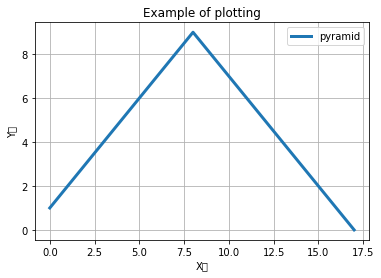

In [134]:
plt.figure()
plt.plot([1,2,3,4,5,6,7,8,9,8,7,6,5,4,3,2,1,0], lw=3, label = 'pyramid')
plt.grid() # 그리드 적용하기
plt.xlabel('X축')       # x축 라벨 적용하기
plt.ylabel('Y축')  # y축 라벨 적용하기
plt.title('Example of plotting') # 타이틀
plt.legend()
plt.show()

# 9. CCTV와 인구현황 그래프로 분석하기

#### 한글 폰트문제 해결
- matplotlib이 기본으로 가진 폰트는 한글을 지원하지 않기 때문에 matplotlib의 폰트를 변경할 필요가 있다.
- Mac인지 Windows인지 나누어 지원

In [135]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

In [136]:
data_result.head()

,소계,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율
구별,,,,,,,
강남구,3238,570500,565550,4950,63167,0.875254,11.169127
강동구,1010,453233,449019,4214,54622,0.938490,12.164741
강북구,831,330192,326686,3506,54813,1.073202,16.778497
강서구,911,603772,597248,6524,72548,1.092344,12.147048
관악구,2109,525515,507203,18312,68082,3.610389,13.423028


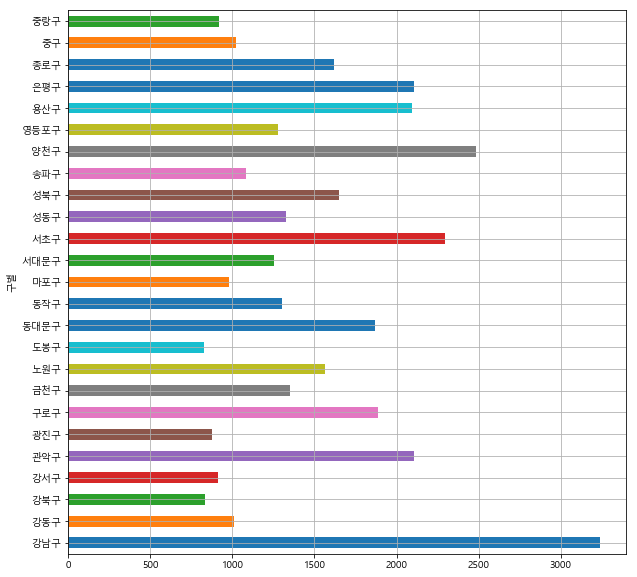

In [137]:
plt.figure()
data_result['소계'].plot(kind='barh', grid=True, figsize=(10,10)) # 수평 막대 그래프를, 그리드를 사용하여, 그림 크기를 10*10으로 지정함.
plt.show()

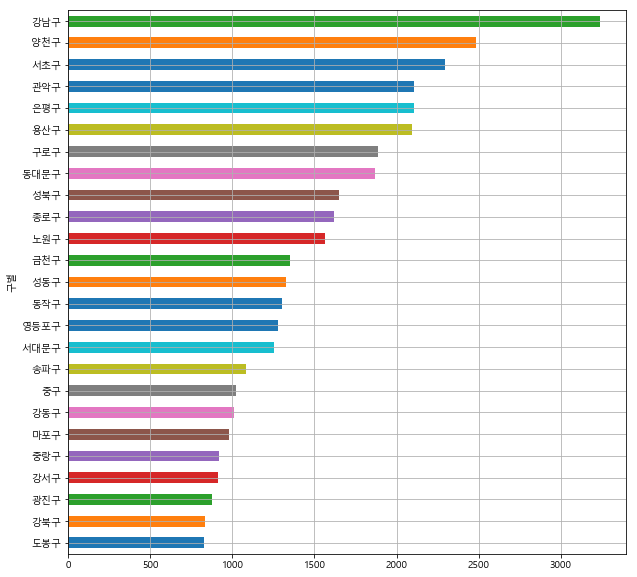

In [138]:
# sort_values 사용
data_result['소계'].sort_values().plot(kind='barh', 
                                     grid=True, figsize=(10,10))
plt.show()

##### 강남구의 CCTV 개수가 월등하다. 인구대비 CCTV 비율을 계산해본다.

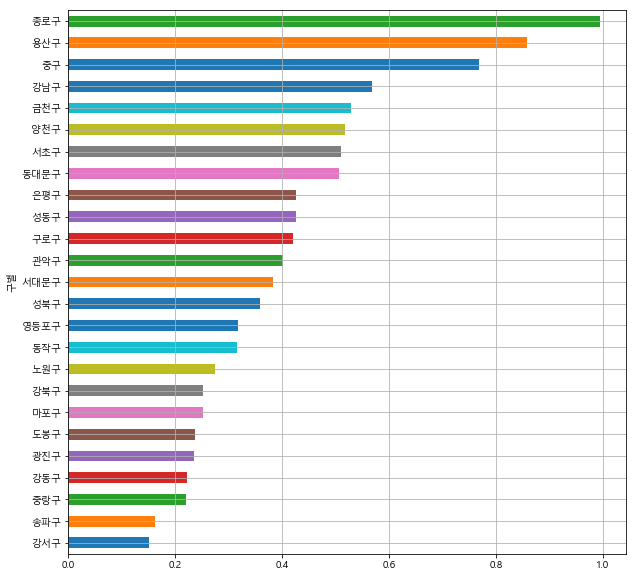

In [140]:
# 인구 대비 CCTV 비율을 구한다.
data_result['CCTV비율'] = data_result['소계'] / data_result['총인구'] * 100

# CCTV 비율을 가지고 수평 막대 그래프를 그린다.
data_result['CCTV비율'].sort_values().plot(kind='barh', 
                                         grid=True, figsize=(10,10))
plt.show()

##### 종로구가 가장 높은 CCTV 비율을 가지고 있다. 종로에 범죄율이 높은지 추가적으로 알아봐야겠다.
##### 강남 3구 대비하여 송파구의 CCTV 비율이 아주 낮은 것을 알 수 있다. 범죄율과 관련해보는 것이 좋겠다.
#### 결과 : 범죄율과 CCTV 비율이 상관관계가 있는 것으로 가설을 세워봐야겠다. 고령화비율과 외국인비율은 낮은 상관관계이거나 관계가 없었다. 향후 범죄율 데이터를 구하여 CCTV 비율과 상관관계를 검증해본다.

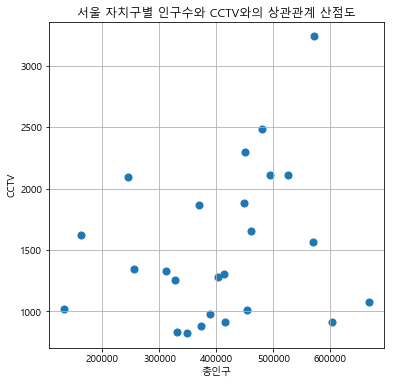

In [141]:
plt.figure(figsize=(6,6))
plt.scatter(data_result['총인구'], data_result['소계'], s=50)
plt.xlabel('총인구')
plt.ylabel('CCTV')
plt.title("서울 자치구별 인구수와 CCTV와의 상관관계 산점도")
plt.grid()
plt.show()

#### 위 데이터를 대표하는 직선을 하나 그려보자.
- polyfit과 poly1d 함수를 사용하여 (x, y_linear)와 (x, y_quadratic) 좌표 쌍들에 대해 선형 및 2차 다항식을 만든다.
- polyfit 함수를 이용해 지정한 특정 차수의 다항식 계수를 계산하고,
- poly1d함수로 그 계수를 사용하여 실제 다항식을 만든다.

In [142]:
# polyfit 함수를 이용해 지정한 특정 차수의 다항식 계수를 계산하고,
fp1 = np.polyfit(data_result['총인구'], data_result['소계'], 1)
fp1

array([1.15151285e-03, 1.04561312e+03])

In [143]:
# poly1d함수로 그 계수를 사용하여 실제 다항식을 만든다.
f1 = np.poly1d(fp1) # y축
fx = np.linspace(100000, 700000, 100) # x축

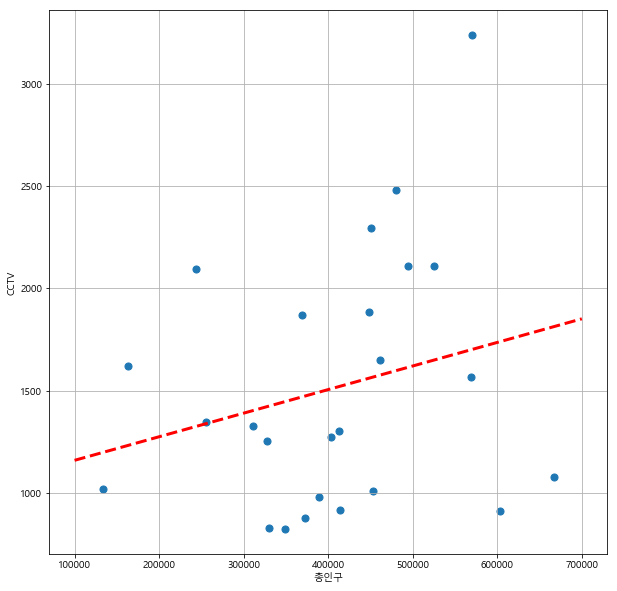

In [144]:
plt.figure(figsize=(10,10))
plt.scatter(data_result['총인구'], data_result['소계'], s=50)
plt.plot(fx, f1(fx), ls='dashed', lw=3, color='r')
plt.xlabel('총인구')
plt.ylabel('CCTV')
plt.grid()
plt.show()

# 10. 조금더 설득력 있는 자료 만들기

In [145]:
fp1 = np.polyfit(data_result['총인구'], data_result['소계'], 1)

f1 = np.poly1d(fp1) # y축
fx = np.linspace(100000, 700000, 100) # x축

# 오차를 추가한다.
data_result['오차'] = np.abs(data_result['소계'] - f1(data_result['총인구']))

df_sort = data_result.sort_values(by='오차', ascending=False)
df_sort.head()

,소계,총인구,내국인,외국인,고령자,외국인 비율,고령자 비율,CCTV비율,오차
구별,,,,,,,,,
강남구,3238,570500,565550,4950,63167,0.875254,11.169127,0.567572,1535.448801
양천구,2482,479978,475949,4029,52975,0.846519,11.130394,0.517107,883.686047
강서구,911,603772,597248,6524,72548,1.092344,12.147048,0.150885,829.864334
용산구,2096,244203,229456,14747,36231,6.426940,15.789955,0.858302,769.183989
송파구,1081,667483,660584,6899,72506,1.044379,10.976045,0.161952,733.228369


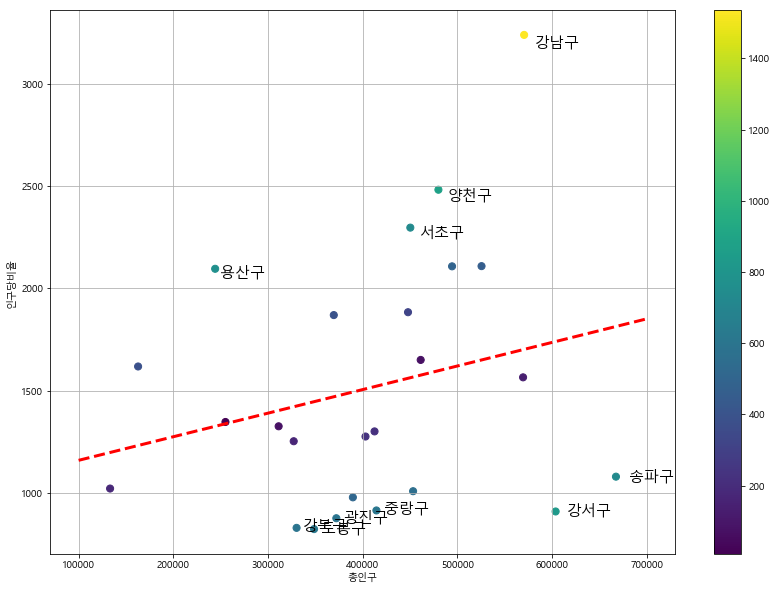

In [146]:
plt.figure(figsize=(14,10))
plt.scatter(data_result['총인구'], data_result['소계'], 
            c=data_result['오차'], s=50)
plt.plot(fx, f1(fx), ls='dashed', lw=3, color='r')

for n in range(10):
    plt.text(df_sort['총인구'][n]*1.02, df_sort['소계'][n]*0.98, 
             df_sort.index[n], fontsize=15)
    
plt.xlabel('총인구')
plt.ylabel('인구당비율')
plt.colorbar()
plt.grid()
plt.show()

* 서울시에서 강남구, 양천구, 서초구, 은평구는 CCTV가 많지만 
* 송파구, 강서구, 도봉구, 마포구는 다른 구에 비해 CCTV 비율이 낮다.
* 강남구는 월등히 많은 CCTV가 설치됐으나, 송파구는 인구수에 비해 너무나도 적은 수의 CCTV를 가지고 있다.